# Dataset ensemble

In [1]:
import h5py
import numpy as np
import pandas as pd
from ensembleset.dataset import DataSet
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import HistGradientBoostingRegressor

import functions.plotting_functions as plot_funcs

## 1. Data preparation

In [2]:
data_df=pd.read_csv('example_data/calories.csv')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11250 entries, 0 to 11249
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     11250 non-null  int64  
 1   Gender      11250 non-null  float64
 2   Age         11250 non-null  int64  
 3   Height      11250 non-null  float64
 4   Weight      11250 non-null  float64
 5   Duration    11250 non-null  float64
 6   Heart_Rate  11250 non-null  float64
 7   Body_Temp   11250 non-null  float64
 8   Calories    11250 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 791.1 KB


In [3]:
data_df.drop('User_ID', axis=1, inplace=True)
train_df, test_df=train_test_split(data_df, test_size=0.5)
train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5625 entries, 0 to 5624
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      5625 non-null   float64
 1   Age         5625 non-null   int64  
 2   Height      5625 non-null   float64
 3   Weight      5625 non-null   float64
 4   Duration    5625 non-null   float64
 5   Heart_Rate  5625 non-null   float64
 6   Body_Temp   5625 non-null   float64
 7   Calories    5625 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 351.7 KB


## 2. Gradient boosting: original data

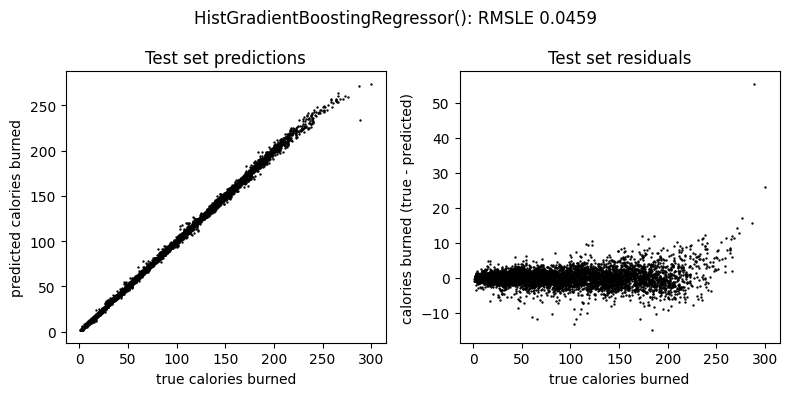

In [4]:
model=HistGradientBoostingRegressor(loss='gamma')
model.fit(train_df.drop('Calories', axis=1), train_df['Calories'])

predictions=model.predict(test_df.drop('Calories', axis=1))
labels=test_df['Calories']
rmsle=np.sqrt(mean_squared_log_error(labels, predictions))

plot_title=f'HistGradientBoostingRegressor(): RMSLE {rmsle:.4f}'
plot_funcs.model_eval(plot_title, 'calories burned', predictions, labels)

## 2. Gradient boosting ensemble model

### 3.1. Generate ensembleset

In [5]:
ensemble_members=30

data_ensemble=DataSet(
    label='Calories',
    train_data=train_df,
    test_data=test_df
)

data_ensemble.make_datasets(
    n_datasets=ensemble_members,
    n_features=7,
    n_steps=3
)


Generating dataset 1 of 30
 Applying spline_features
 Applying ratio_features
 Applying poly_features

Generating dataset 2 of 30
 Applying exponential_features
 Applying ratio_features
 Applying log_features

Generating dataset 3 of 30
 Applying sum_features
 Applying difference_features
 Applying exponential_features

Generating dataset 4 of 30
 Applying difference_features
 Applying exponential_features
 Applying spline_features

Generating dataset 5 of 30
 Applying exponential_features
 Applying difference_features
 Applying sum_features

Generating dataset 6 of 30
 Applying difference_features
 Applying exponential_features
 Applying spline_features

Generating dataset 7 of 30
 Applying difference_features
 Applying poly_features
 Applying log_features

Generating dataset 8 of 30
 Applying spline_features
 Applying ratio_features
 Applying poly_features

Generating dataset 9 of 30
 Applying sum_features
 Applying difference_features
 Applying log_features

Generating dataset 10 o

### 3.2. Stage I model

In [6]:
stage_one_models={}
stage_one_test_predictions={}

with h5py.File('data/dataset.h5', 'r') as hdf:
    for i in range(ensemble_members):

        print(f'Fitting model {i}')
    
        stage_one_models[i]=HistGradientBoostingRegressor(loss='gamma')
        stage_one_models[i].fit(hdf[f'train/{i}'], hdf[f'train/labels'])
        stage_one_test_predictions[i]=stage_one_models[i].predict(hdf[f'test/{i}'])

    stage_two_training_df=pd.DataFrame.from_dict(stage_one_test_predictions)
    stage_two_training_df['labels']=hdf[f'test/labels']

stage_two_training_df.head()

Fitting model 0
Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9
Fitting model 10
Fitting model 11
Fitting model 12
Fitting model 13
Fitting model 14
Fitting model 15
Fitting model 16
Fitting model 17
Fitting model 18
Fitting model 19
Fitting model 20
Fitting model 21
Fitting model 22
Fitting model 23
Fitting model 24
Fitting model 25
Fitting model 26
Fitting model 27
Fitting model 28
Fitting model 29


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,labels
0,191.222291,189.906519,190.795229,190.382065,191.128371,192.242869,189.833264,190.523765,191.439890,165.674664,...,190.930605,189.550996,189.688598,193.021969,189.738806,192.280230,190.794587,166.683484,175.903669,189.0
1,161.061053,163.373145,164.191849,163.020815,162.986476,162.619796,163.748561,162.815869,165.011014,142.741846,...,164.389080,160.750090,166.676967,166.795114,163.510930,163.897473,165.318126,143.173983,154.719909,164.0
2,38.337547,34.058690,36.409734,35.676052,36.402575,38.030747,34.258326,38.207268,35.737644,29.722013,...,35.563978,38.497731,33.631093,38.124952,38.067125,31.667181,37.913486,32.197618,36.914114,36.0
3,126.597209,125.037015,123.466787,125.051849,123.626804,125.289477,125.567876,123.359878,121.673523,109.973048,...,123.758820,126.074416,122.402792,125.351424,124.725714,124.757845,127.108364,110.039281,114.107747,124.0
4,37.821832,32.642845,34.677116,34.822835,35.011725,33.531163,36.747030,35.924334,35.482135,33.012236,...,34.377605,37.027953,33.638951,35.021589,35.251934,34.506836,35.632883,29.896361,34.114549,35.0


### 3.2. Stage II model

In [7]:
scores=cross_val_score(
    HistGradientBoostingRegressor(loss='gamma'),
    stage_two_training_df.drop('labels', axis=1),
    stage_two_training_df['labels'],
    scoring='neg_mean_squared_log_error',
    n_jobs=-1,
    cv=7
)

print(f'Cross-validation RMSLE: {np.mean(np.sqrt(-scores)):.4f} +/- {np.std(np.sqrt(-scores)):.4f}')

Cross-validation RMSLE: 0.0401 +/- 0.0111
